# New York City Airbnb Open Data

This analysis has the purpose of extracting helpful insights from accomodations in NYC, analyzing prices, types of accomodations and more.

In [1]:
# Importing all packages needed
import os
import numpy as np
import pandas as pd
from zipfile import ZipFile
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.ticker as mtick
import matplotlib.patches as mpatches
from scipy import stats
import scikit_posthocs as sp
from fitter import Fitter
from scipy import stats

In [2]:
# Sets theme for the charts displayed
sns.set_theme(context='notebook',style="whitegrid",palette='Set2')

In [3]:
# Initializes the connection with the API from Kaggle
kaggle_token = {"username":"","key":""}

os.environ['KAGGLE_USERNAME'] = kaggle_token['username']
os.environ['KAGGLE_KEY'] = kaggle_token['key']

from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

In [4]:
nyc_airbnb = pd.DataFrame(api.datasets_list(search='New York City Airbnb Open Data')).head()
nyc_airbnb.head()

,subtitleNullable,creatorNameNullable,creatorUrlNullable,totalBytesNullable,urlNullable,licenseNameNullable,descriptionNullable,ownerNameNullable,ownerRefNullable,titleNullable,...,topicCount,viewCount,voteCount,currentVersionNumber,hasCurrentVersionNumber,usabilityRating,hasUsabilityRating,tags,files,versions
0,"Airbnb listings and metrics in NYC, NY, USA (2...",Dgomonov,dgomonov,2562692,https://www.kaggle.com/datasets/dgomonov/new-y...,CC0: Public Domain,None,Dgomonov,dgomonov,New York City Airbnb Open Data,...,0,990566,2756,3,True,1.000000,True,"[{'nameNullable': 'business', 'descriptionNull...",[],[]
1,New York Airbnb Open Data,Arian Azmoudeh,arianazmoudeh,10964528,https://www.kaggle.com/datasets/arianazmoudeh/...,"Database: Open Database, Contents: © Original ...",None,Arian Azmoudeh,arianazmoudeh,Airbnb Open Data,...,0,83471,202,1,True,1.000000,True,"[{'nameNullable': 'business', 'descriptionNull...",[],[]
2,,Arthur de Andrade Almeida,arthbr11,159574397,https://www.kaggle.com/datasets/arthbr11/new-y...,Unknown,None,Arthur de Andrade Almeida,arthbr11,New York City Airbnb Open Data,...,0,1717,3,1,True,0.176471,True,[],[],[]
3,Includes over 15 states and 30 unique cities/c...,Tam Le,tamle507,19585407,https://www.kaggle.com/datasets/tamle507/airbn...,CC BY-NC-SA 4.0,None,Tam Le,tamle507,Airbnb USA Listings,...,0,4072,14,1,True,1.000000,True,"[{'nameNullable': 'united states', 'descriptio...",[],[]
4,,Peniel RAR,penielrar,5527,https://www.kaggle.com/datasets/penielrar/newy...,Unknown,None,Peniel RAR,penielrar,New-york-city-airbnb-open-data,...,0,86,1,1,True,0.125000,True,[],[],[]


In [5]:
ref = nyc_airbnb.loc[0,'ref']
!kaggle datasets download -d {ref}

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
#The documents from the Zip File are extracted
zf = ZipFile('new-york-city-airbnb-open-data.zip')
zf.extractall()
zf.close()

## Data preview

In [7]:
nyc_airbnb_data = pd.read_csv('AB_NYC_2019.csv')

In [8]:
nyc_airbnb_data['last_review'] = pd.to_datetime(nyc_airbnb_data['last_review'])

In [9]:
nyc_airbnb_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaT,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [10]:
# Preview of how the shape of the data set and missing values
print(nyc_airbnb_data.shape)
print(nyc_airbnb_data.isnull().sum())

(48895, 16)
id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64


* It is not necessary to have the hosts' names, their ID's are completed so there is no need to make modifications to that column.
* 16 missing values in the name of the airbnb's accomodations are not a big deal, since out data set contains 48,895 rows.
* Last review and reviews per month have the same number of missing values, let's check what are the cases it could happen.

In [11]:
# Getting che possible cases when last review and reviews per month have missing values
nyc_airbnb_data[((nyc_airbnb_data['last_review'].notnull()) & (nyc_airbnb_data['reviews_per_month'].isnull())) | ((nyc_airbnb_data['last_review'].isnull()) & (nyc_airbnb_data['reviews_per_month'].notnull()))]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


Missing values on the "last_review" column are the same rows in which there are missing values for the "reviews_per_month" column.

* Last column is not meaningful, therefore, it will be removed, as well as the host name column.
* For missing values on the "reviews_per_month" column, zero values will be imputed.

In [12]:
nyc_airbnb_data.drop(['last_review','host_name'],axis=1,inplace=True)
nyc_airbnb_data['reviews_per_month'] = np.where(nyc_airbnb_data['reviews_per_month'].isnull(),0,nyc_airbnb_data['reviews_per_month'])

## Exploratory Data Analysis

In order to understand better the dataset, an explotatory analysis will be executed.

In [13]:
nyc_airbnb_data.dropna().describe(include='all')

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.887900e+04,48879,4.887900e+04,48879,48879,48879.000000,48879.000000,48879,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000,48879.000000
unique,NaN,47905,NaN,5,221,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Hillside Hotel,NaN,Manhattan,Williamsburg,NaN,NaN,Entire home/apt,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,18,NaN,21652,3918,NaN,NaN,25402,NaN,NaN,NaN,NaN,NaN,NaN
mean,1.902062e+07,NaN,6.763013e+07,NaN,NaN,40.728945,-73.952168,NaN,152.722355,7.011027,23.281205,1.091248,7.145891,112.788989
std,1.098282e+07,NaN,7.862070e+07,NaN,NaN,0.054529,0.046160,NaN,240.186804,20.016000,44.556149,1.597433,32.957738,131.613322
min,2.539000e+03,NaN,2.438000e+03,NaN,NaN,40.499790,-74.244420,NaN,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
25%,9.474248e+06,NaN,7.816856e+06,NaN,NaN,40.690090,-73.983070,NaN,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000
50%,1.968643e+07,NaN,3.079133e+07,NaN,NaN,40.723080,-73.955680,NaN,106.000000,3.000000,5.000000,0.370000,1.000000,45.000000
75%,2.915334e+07,NaN,1.074344e+08,NaN,NaN,40.763110,-73.936280,NaN,175.000000,5.000000,24.000000,1.580000,2.000000,227.000000


#### Data to clean
* There are some prices with value zero, which are not valid values.
* The maximum value for prices is a lot bigger than the median.
* The maximum value of minimum nights is 1250, which is more than what a year can have, so it can be standardized to a year.

In [14]:
nyc_airbnb_data[nyc_airbnb_data['price']==0]['id'].count()

11

In [15]:
# Zero values are replaced with the median
nyc_airbnb_data['price'] = np.where(nyc_airbnb_data['price']==0, nyc_airbnb_data['price'].median(),nyc_airbnb_data['price'])

#### Analyzing neighbourhoods and boroughs

In [16]:
neighbourhoods = pd.DataFrame(nyc_airbnb_data.groupby('neighbourhood')['id'].count()).sort_values('id',ascending=False).reset_index()

neighbourhood_percentage = pd.DataFrame(nyc_airbnb_data.groupby('neighbourhood_group')['id'].count()).sort_values('id',ascending=False).reset_index()                   
neighbourhood_percentage['listings_percent'] = 100*neighbourhood_percentage['id'] / sum(neighbourhood_percentage['id'])

neighbourhood_rooms = pd.DataFrame(nyc_airbnb_data.groupby(['neighbourhood_group','room_type'])['id'].count()).sort_values('id',ascending=False).reset_index()
neighbourhood_rooms['listings_percent'] = 100*neighbourhood_rooms['id'] / sum(neighbourhood_rooms['id'])

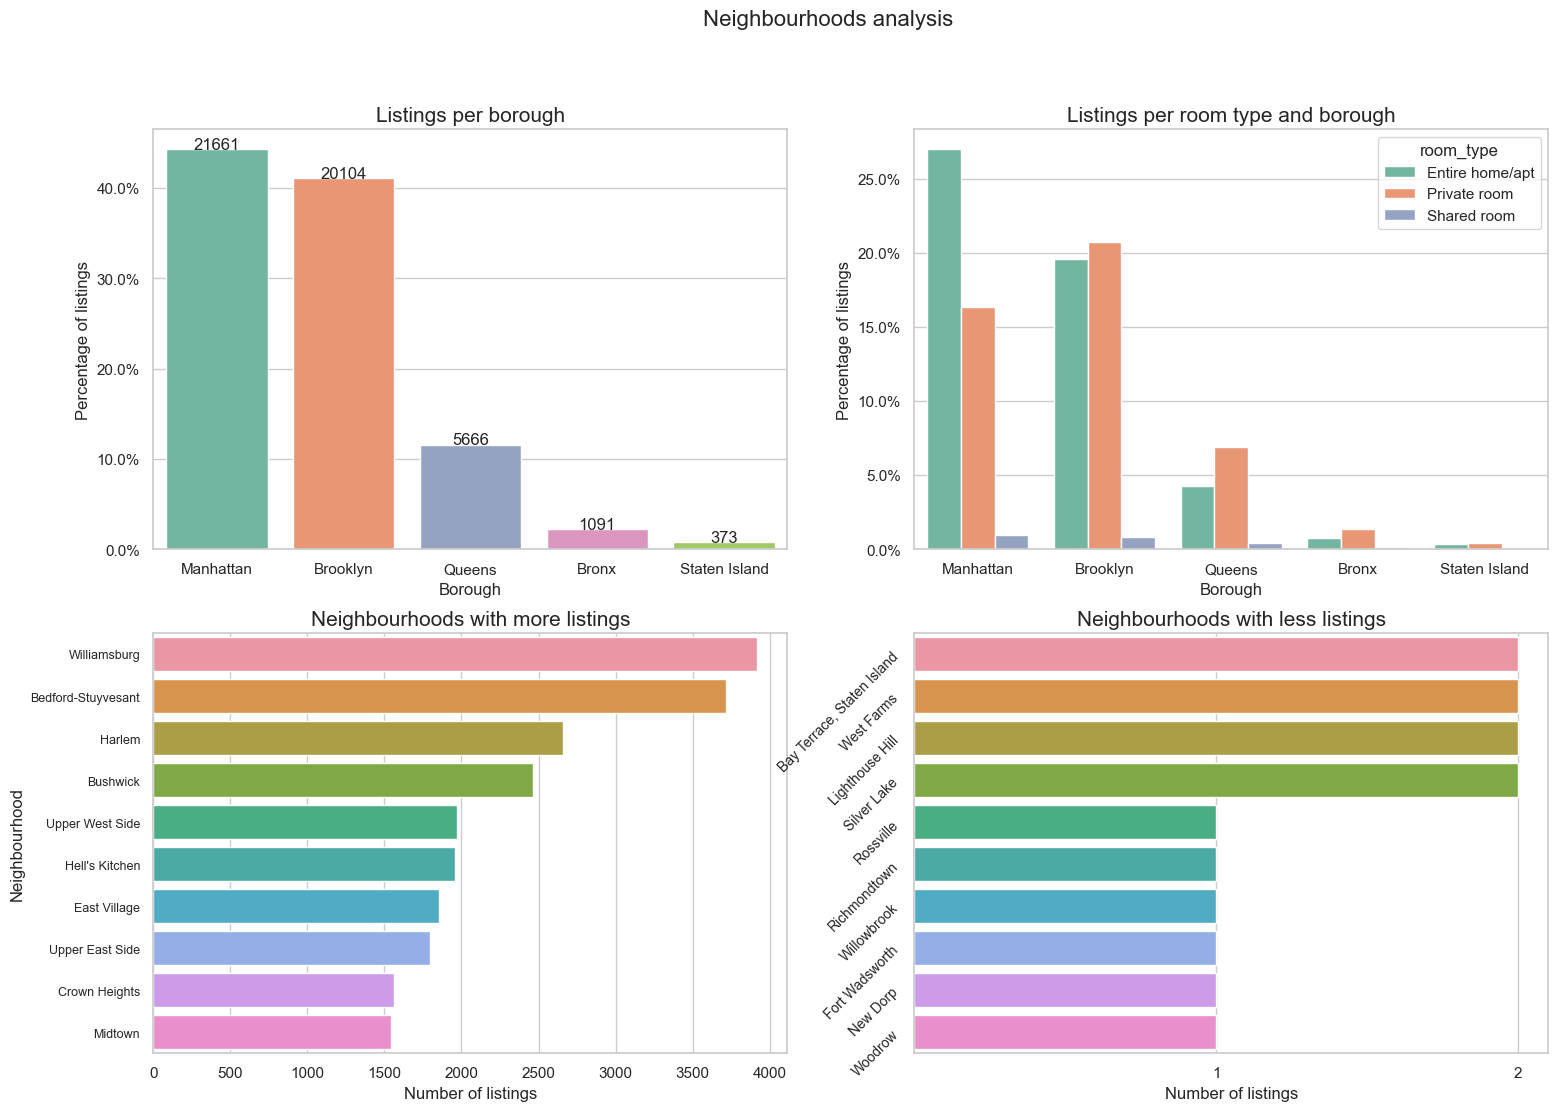

In [17]:
fig , axes = plt.subplots(2,2, figsize=(18,12))

plt.rcParams["figure.figsize"] = [6.00, 3.50]
# plt.rcParams["figure.autolayout"] = True

sns.barplot(data=neighbourhood_percentage , x='neighbourhood_group',y='listings_percent', ax = axes[0,0]) 
axes[0,0].set_title('Listings per borough',fontsize=15)
axes[0,0].set_ylabel('Percentage of listings')
axes[0,0].set_xlabel('Borough')
axes[0,0].yaxis.set_major_formatter(mtick.PercentFormatter())
for name,row in neighbourhood_percentage.iterrows():
    axes[0,0].text(row.name, row.listings_percent,s=row.id , ha='center')


sns.barplot(data=neighbourhood_rooms, x='neighbourhood_group',y='listings_percent',hue='room_type',ax=axes[0,1])
axes[0,1].set_title('Listings per room type and borough',fontsize=15)
axes[0,1].set_xlabel('Borough')
axes[0,1].set_ylabel('Percentage of listings')
axes[0,1].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(data=neighbourhoods.head(10),y='neighbourhood',x='id', ax=axes[1,0]) 
axes[1,0].set_title('Neighbourhoods with more listings',fontsize=15)
axes[1,0].set_yticklabels(neighbourhoods['neighbourhood'].head(10), fontsize=9)
axes[1,0].set_ylabel('Neighbourhood')
axes[1,0].set_xlabel('Number of listings')

sns.barplot(data=neighbourhoods.tail(10),y='neighbourhood',x='id', ax=axes[1,1]) 
axes[1,1].set_title('Neighbourhoods with less listings',fontsize=15)
axes[1,1].set_yticklabels(neighbourhoods['neighbourhood'].tail(10), fontsize=10, rotation=45)
axes[1,1].set_ylabel('')
axes[1,1].set_xlabel('Number of listings')
axes[1,1].set_xticks([1,2])

plt.suptitle('Neighbourhoods analysis',fontsize=16)
plt.show()

In [18]:
neighbourhoods['cumulative_percentage'] = 100*neighbourhoods['id'].cumsum()/sum(neighbourhoods['id'])
neighbourhoods.head(10)

,neighbourhood,id,cumulative_percentage
0,Williamsburg,3920,8.017180
1,Bedford-Stuyvesant,3714,15.613048
2,Harlem,2658,21.049187
3,Bushwick,2465,26.090602
4,Upper West Side,1971,30.121689
5,Hell's Kitchen,1958,34.126189
6,East Village,1853,37.915942
7,Upper East Side,1798,41.593210
8,Crown Heights,1564,44.791901
9,Midtown,1545,47.951733


According to the charts above:
* Brooklyn and Manhattan have more than 80% of the listings in New York with more than 40k accomodations.
* Entire homes and apartments in Manhattan represent more than 25% of the total accomodations in NYC.
* More than 20% of private rooms are in Brooklyn.
* Bronx and Staten Island have no shared rooms.
* The chart that shows neighbourhoods with more listings represent almost 50% of the total, having Williamsburg as the principal neighbourhood with 8% of the total accomodations in NYC.
* Only 6 neighbourhoods have just one listing, the rest have at least 2.

The fact that most of the listings are Entire Homes/Apartments can significally impact prices.

#### Analyzing prices

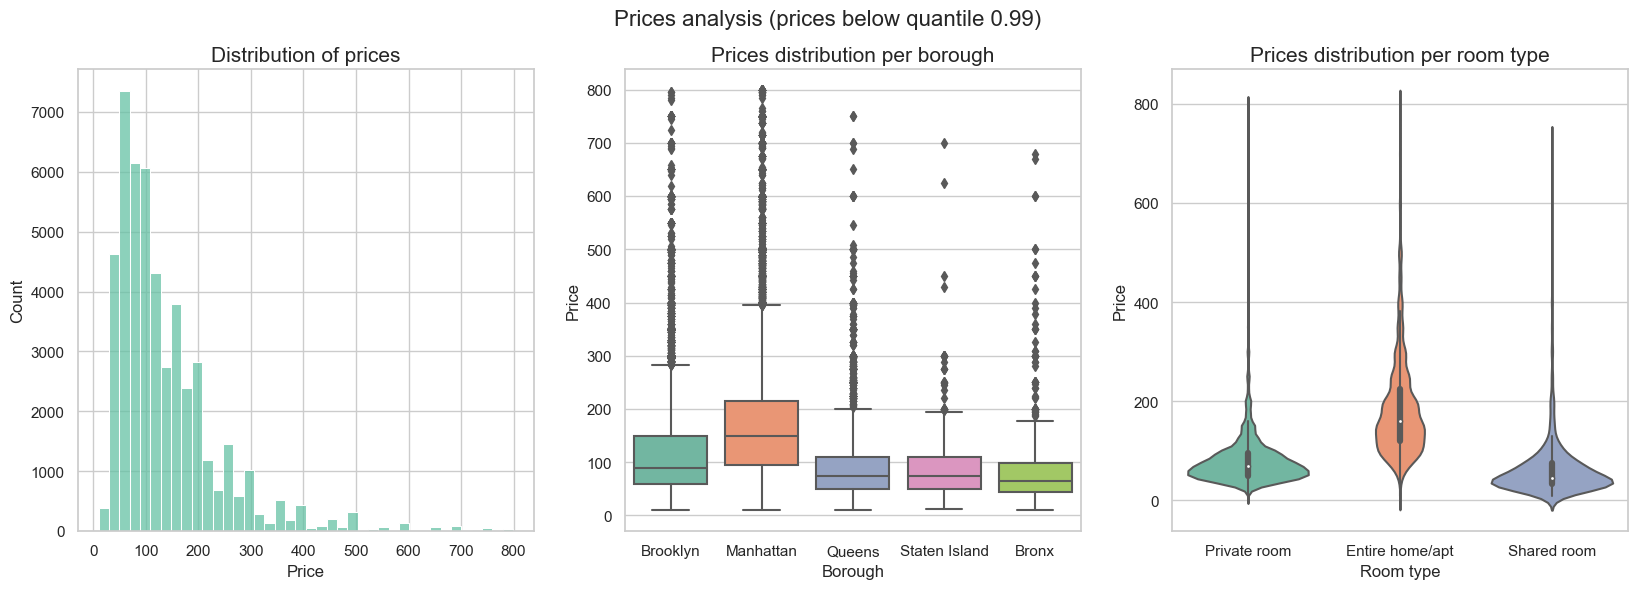

In [19]:
# Only prices below quantile 99.5 will be considered

fig, axes = plt.subplots(1,3,figsize=(20,6))

sns.histplot(data=nyc_airbnb_data[nyc_airbnb_data['price']<=np.quantile(nyc_airbnb_data['price'],0.99)], x='price',ax=axes[0],bins=40)
sns.boxplot(data=nyc_airbnb_data[nyc_airbnb_data['price']<=np.quantile(nyc_airbnb_data['price'],0.99)],y='price',x='neighbourhood_group',ax=axes[1])
sns.violinplot(data=nyc_airbnb_data[nyc_airbnb_data['price']<=np.quantile(nyc_airbnb_data['price'],0.99)],y='price',x='room_type',ax=axes[2])

axes[0].set_xlabel('Price')
axes[0].set_title('Distribution of prices',fontsize=15)

axes[1].set_ylabel('Price')
axes[1].set_xlabel('Borough')
axes[1].set_title('Prices distribution per borough',fontsize=15)

axes[2].set_ylabel('Price')
axes[2].set_xlabel('Room type')
axes[2].set_title('Prices distribution per room type',fontsize=15)
fig.suptitle('Prices analysis (prices below quantile 0.99)',fontsize=16)

plt.show()

Distribution of prices
* Prices distribution looks like a Beta or Gamma distribution, to confirm this statement, a test value will be executed later on.
* Prices median is 106, and seems like most of values are lower than 300, the boxplots can show us more about this. 

Prices per borough
* There is a visible difference between prices in Manhattan and the rest of the boroughs.
* Queens, Staten Island and Bronx seem to have pretty similar prices.


Prices per room type
* Private and shared room show similarities, most listings seem to offer a price between 50 and 100, nevertheless, private room seems to be a little bit higher than for shared room.
* Entire homes and apartments show higher values, this makes total sense, since they could offer more than one bedroom or services.

It might be interesting to see if there is a statistical differences on prices between neighrbourhoods, especially between Queens, Staten Island and Bronx.
To determine if they are statistically different or not, a statistical test will be executed.

In [20]:
room_type_percentage = pd.DataFrame(nyc_airbnb_data.groupby('room_type')['id'].count()).sort_values('id',ascending=False).reset_index()
room_type_percentage['listings_percent'] = 100*room_type_percentage['id'] / sum(room_type_percentage['id'])

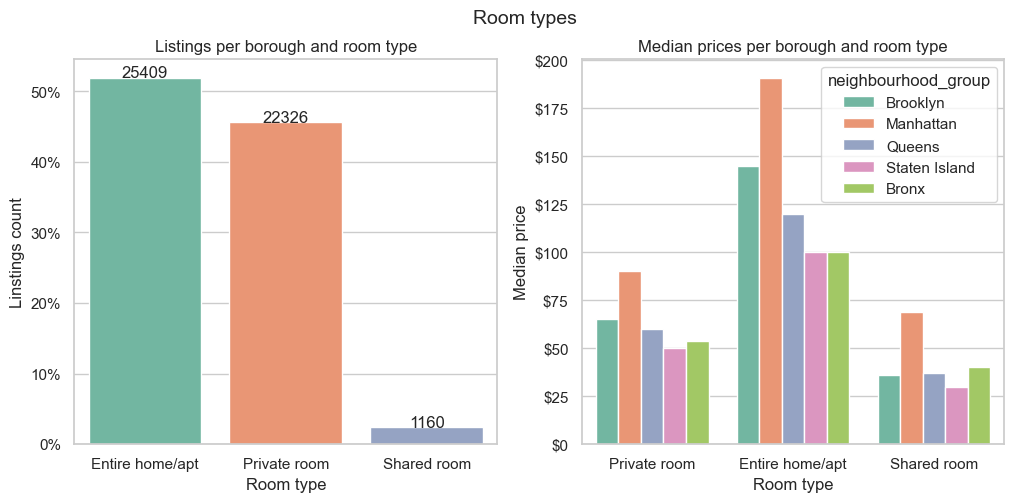

In [21]:
# Borough and room type prices
fig, ax = plt.subplots(1,2,figsize=(12,5))
plt.rcParams["figure.figsize"] = [6.00, 3.50]

sns.barplot(data=room_type_percentage , x='room_type',y='listings_percent', ax=ax[0]) 
ax[0].set_title('Listings per room type',fontsize=15)
ax[0].set_ylabel('Number of listings')
ax[0].set_xlabel('Room type')
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter())
for name,row in room_type_percentage.iterrows():
    ax[0].text(row.name, row.listings_percent,s=row.id , ha='center')

sns.barplot(data=nyc_airbnb_data, x='room_type',y='price',estimator=np.median,ax=ax[1],ci=None,hue='neighbourhood_group')
ax[1].yaxis.set_major_formatter('${x:1.0f}')
# Median prices are displayed, so there is no need of filtering with quantile 99.5

ax[0].set_title('Listings per borough and room type',fontsize=12)
ax[1].set_title('Median prices per borough and room type',fontsize=12)
ax[0].set_xlabel('Room type')
ax[1].set_xlabel('Room type')
ax[0].set_ylabel('Linstings count')
ax[1].set_ylabel('Median price')
plt.suptitle('Room types',fontsize=14)

plt.show()

According to the charts above, it is interesting to see that:
* More than 50% of the listings are Entire home/apt, if we add Private Rooms they represent more than 95% of the total accomodations.
* Entire homes and apartments are more expensive in every borough, which makes sense according to the context.
* Prices for private rooms are pretty similar in all boroughs (between $50 and $70 per night) but Manhattan.
* Shared rooms are more expensive in Bronx than in Brooklyn.
* People could pay aproximately the same for a shared room in manhattan and a private room in brooklyn.

#### Kruskal Wallis test
A Kruskal Wallis test will be used to prove if there is (or not) statistical difference between median prices between boroughs, especially between Queens, Bronx and Staten Island. This test works under the assumption that the groups are independent and they are not normally distributed.
* H0: All medians across groups are statistically equal.
* H1: There is at least one pair of medians that are different from each other.

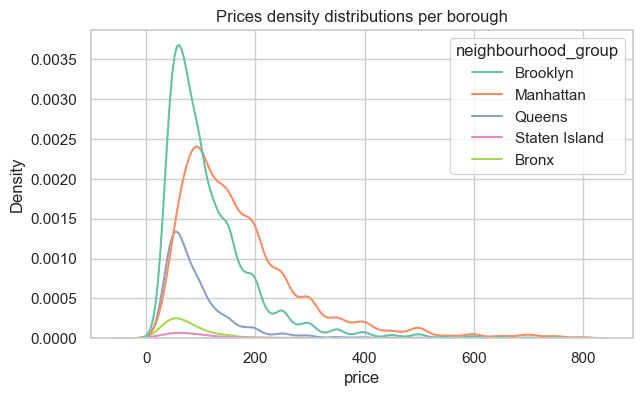

In [22]:
# Idetification of the distribution of prices for each group
plt.rcParams["figure.figsize"] = [7.00, 4.00]
sns.kdeplot(data=nyc_airbnb_data[nyc_airbnb_data['price']<=np.quantile(nyc_airbnb_data['price'],0.99)], x='price',hue='neighbourhood_group')
plt.title('Prices density distributions per borough')
plt.show()

The plot does not show that the prices per group are normally distributed.

In [23]:
# Stratified sampling per group, 70% of data fro each group will be taken.
sample = nyc_airbnb_data[nyc_airbnb_data['price']<=np.quantile(nyc_airbnb_data['price'],0.99)].groupby('neighbourhood_group', group_keys=False).apply(lambda x: x.sample(frac=0.7))

In [24]:
# Each group of values is created
brooklyn = sample[sample['neighbourhood_group']=='Brooklyn']['price'].values
manhattan = sample[sample['neighbourhood_group']=='Manhattan']['price'].values
queens = sample[sample['neighbourhood_group']=='Queens']['price'].values
staten_island = sample[sample['neighbourhood_group']=='Staten Island']['price'].values
bronx = sample[sample['neighbourhood_group']=='Bronx']['price'].values

In [25]:
stats.kruskal(brooklyn, manhattan,queens, staten_island, bronx)

KruskalResult(statistic=4842.492808456181, pvalue=0.0)

The p-value < alpha=0.05, H0 is rejected, which means that there is at least one median that is different from another one in the group.

#### Dunn test

Dunn test will be used to identify the pair of medians that are different between them,
* H0: median of group i is equal as median of group j
* H1: median of group i is different from median of group j

Where i, j are either Brooklyn, Manhattan, Queens, Staten Island or Bronx

In [26]:
# Dunn test to see which pair of medians are different
dunn_results = sp.posthoc_dunn([brooklyn,manhattan,queens, staten_island, bronx], p_adjust = 'bonferroni')
dunn_results.rename(columns={1:'Brooklyn',2:'Manhattan',3:'Queens',4:'Staten Island', 5:'Bronx'},inplace=True)
dunn_results.index = ['Brooklyn','Manhattan','Queens','Staten Island','Bronx']
dunn_results

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Brooklyn,1.000000e+00,0.000000e+00,1.067937e-60,1.289729e-06,3.654431e-40
Manhattan,0.000000e+00,1.000000e+00,0.000000e+00,4.837871e-53,6.375489e-206
Queens,1.067937e-60,0.000000e+00,1.000000e+00,1.000000e+00,3.571374e-06
Staten Island,1.289729e-06,4.837871e-53,1.000000e+00,1.000000e+00,1.960750e-01
Bronx,3.654431e-40,6.375489e-206,3.571374e-06,1.960750e-01,1.000000e+00


In [27]:
# If the p-value <= alpha=0.05, we reject H0 for the group i,j, which means that the pair of medians are statistically different.
# If p-value > 0.05, the medians are not statistically different.
dunn_results > 0.05

,Brooklyn,Manhattan,Queens,Staten Island,Bronx
Brooklyn,True,False,False,False,False
Manhattan,False,True,False,False,False
Queens,False,False,True,True,False
Staten Island,False,False,True,True,True
Bronx,False,False,False,True,True


Therefore, with a level of confidence of 95%, the pairs of medians that are statistically equal are:
* Staten Island and Bronx
* Staten Islan and Queens
* Queens and Staten Island

In [28]:
np.median(queens)

75.0

This means that 50% of the prices that customers will find for accomodations in Queens, Bronx or Staten Island will be below $75.

#### Data modeling
Fitting a distribution model allows us to use the proprieties of the distribution to get more information about the data.
To have a better result, only prices below 99.5 will be used.

In [29]:
# Splitting listings with "normal prices" as the ones below the quantile 0.99, the rest will be considered as high price listings.
normal_prices = nyc_airbnb_data[nyc_airbnb_data['price']<=np.quantile(nyc_airbnb_data['price'],0.99)]
high_prices   = nyc_airbnb_data[nyc_airbnb_data['price']>np.quantile(nyc_airbnb_data['price'],0.99)]

Fitting 4 distributions: 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
exponnorm,0.000068,1684.137314,-986701.876952,inf,0.034127,1.977539e-49
betaprime,0.000074,1649.891068,-982709.688446,inf,0.041820,5.069453e-74
gamma,0.000096,1773.384211,-970463.423884,inf,0.083055,5.141613e-291
beta,0.000096,1764.959449,-970023.862941,inf,0.083053,5.318642e-291


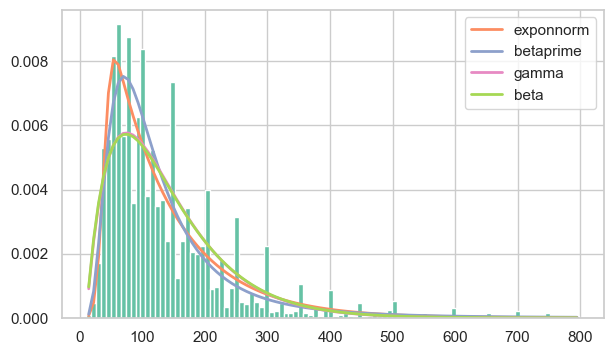

In [30]:
dist = Fitter(normal_prices['price'].values, distributions=['gamma','beta','betaprime','exponnorm'],density=True)
dist.fit()
dist.summary()

Kolmogorov Smirnoff test is used to determine the significance of the test to prove if values follow the same distribution as the one suggested.
* H0: Prices values follow the distribution suggested.
* H1: Prices values come from a different distribution than the suggested.

Beta prime (beta inverted function) is the one that has the lowest AIC value, therefore, this would be the distribution that might fit better, nevertheless, according to the Kolmogorov-Smirnoff test, the p-value is less than 0.05, which indicates that there is no statistical evidence to say that our data follows this distribution.

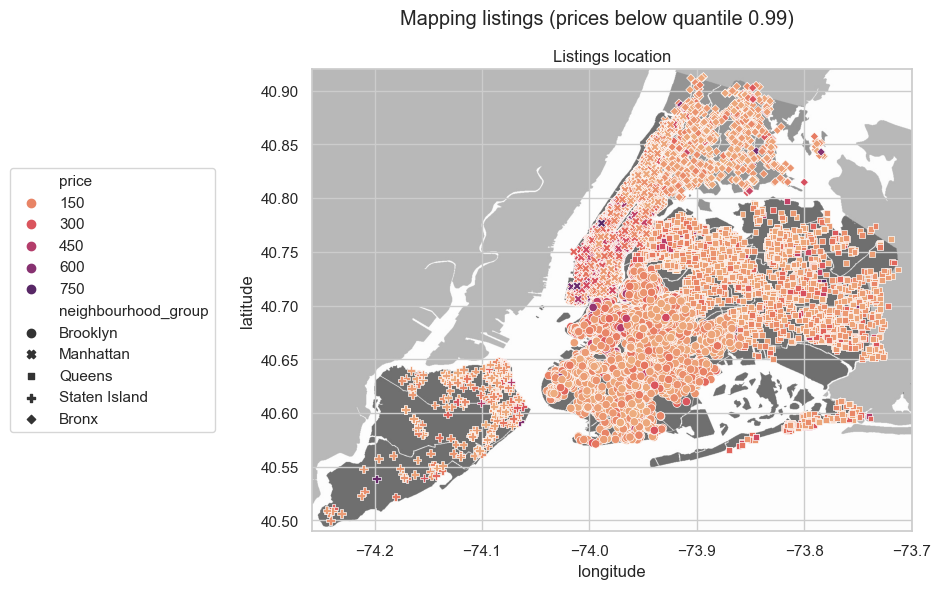

In [31]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

sns.scatterplot(data=normal_prices, x='longitude',y='latitude',style='neighbourhood_group',hue='price',ax=ax,palette=sns.color_palette("flare", as_cmap=True))

ax.set_title('Listings location')
ax.legend_.set_title('Neighbourhoood group')
ax.legend(loc='center right', bbox_to_anchor=(-0.15, 0.5))

# Read NYC map
img = Image.open('New_York_City_.png')
ax.imshow(img,extent=[-74.258, -73.7, 40.49,40.92])

fig.suptitle('Mapping listings (prices below quantile 0.99)')

plt.show()

Even though there are some outliers on the prices column, and as it has been identified before and taking in consideration that the price for all room types and neighbourhoods is $106, the map show that there are even some listings 10 times more expensive than the median, but also that at least on of those are located in every borough.

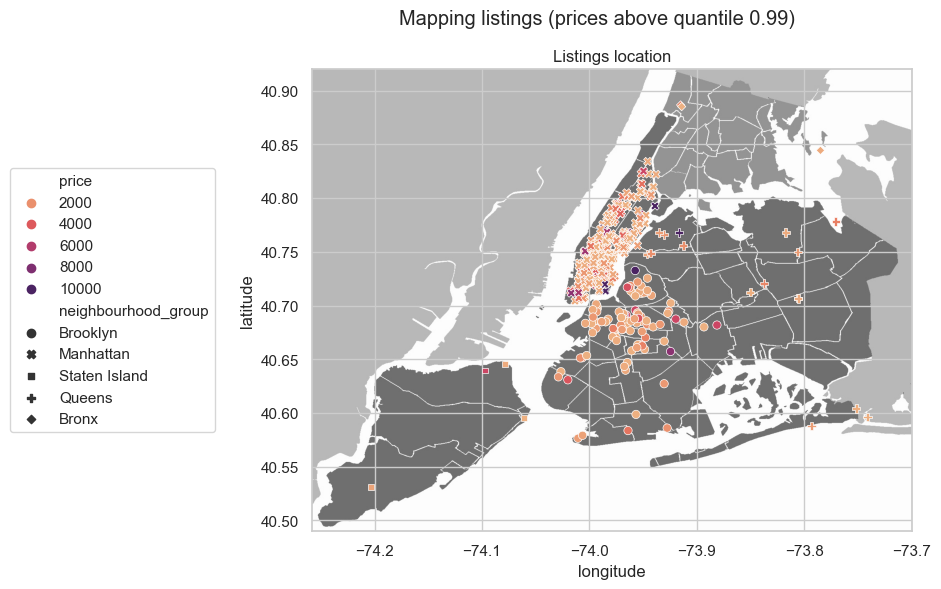

In [32]:
fig, ax = plt.subplots(1,1,figsize=(12,6))

sns.scatterplot(data=high_prices, x='longitude',y='latitude',style='neighbourhood_group',hue='price',ax=ax,palette=sns.color_palette("flare", as_cmap=True),sizes=30)
ax.legend(loc='center right', bbox_to_anchor=(-0.15, 0.5))
ax.imshow(img,extent=[-74.258, -73.7, 40.49,40.92])

ax.set_title('Listings location')
fig.suptitle('Mapping listings (prices above quantile 0.99)')

plt.show()

The listings shown in the charts above show the one with prices above the quantile 0.99, it means that only 1% of the accomodations have prices from $2,000 to $10,000 a night.
* Most of them are located in Manhattan
* Brooklyn is the second place to find these listings
* Most of them are located in the center of NYC

#### Analyazing minimum nights required

In [33]:
# "minimum_nights_a_year" will be created in order to have values in the same scope for all listings
# if a listing can be rented for at least 1 year, then 365 days is set as the minimum nights to rent, any other case is within the same scope
nyc_airbnb_data['minimum_nights_a_year'] =  np.where(nyc_airbnb_data['minimum_nights']>=365 , 365, nyc_airbnb_data['minimum_nights'])

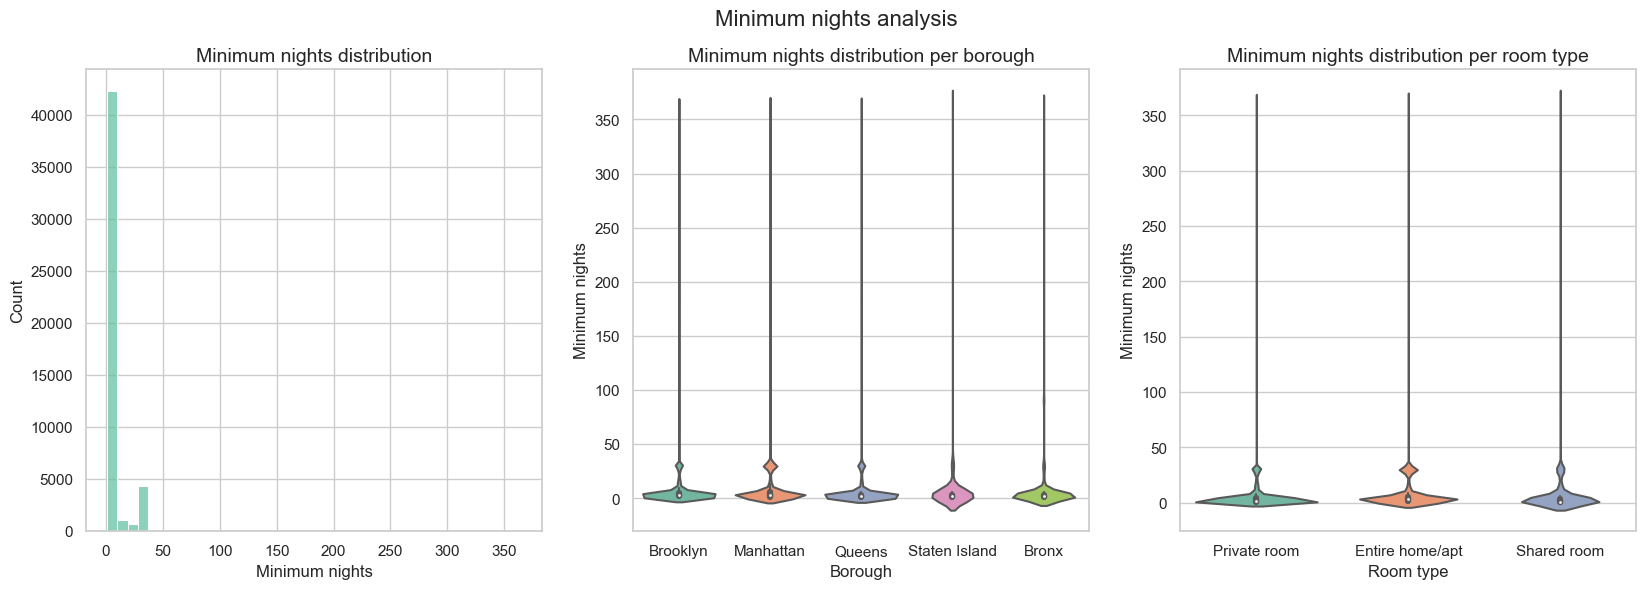

In [34]:
# Analizing prices
fig, axes = plt.subplots(1,3,figsize=(20,6))
plt.rcParams["figure.figsize"] = [6.00, 3.50]

sns.histplot(data=nyc_airbnb_data, x='minimum_nights_a_year',bins=40,ax=axes[0])
sns.violinplot(data=nyc_airbnb_data,y='minimum_nights_a_year',x='neighbourhood_group',ax=axes[1])
sns.violinplot(data=nyc_airbnb_data,y='minimum_nights_a_year',x='room_type',ax=axes[2])

axes[0].set_xlabel('Minimum nights')
axes[1].set_ylabel('Minimum nights')
axes[2].set_ylabel('Minimum nights')
axes[1].set_xlabel('Borough')
axes[2].set_xlabel('Room type')
axes[0].set_title('Minimum nights distribution',fontsize=14)
axes[1].set_title('Minimum nights distribution per borough',fontsize=14)
axes[2].set_title('Minimum nights distribution per room type',fontsize=14)
fig.suptitle('Minimum nights analysis',fontsize=16)

plt.show()

* Even though there are several cases when people have to stay a long time in the listings so it can be rented, most listings are required to be rented by only a few days.
* Brooklyn, Manhattan and Queens seem to have several accomodations with more than 25 nights as a minimum requirement to stay.
* All types of accomodations have the same pattern for the minimum nights to stay, but mostly entire homes / apartments.

In [35]:
minimum_nights = pd.DataFrame(nyc_airbnb_data.groupby(['minimum_nights_a_year','room_type'])['id'].count()).reset_index()

In [36]:
ent_home = minimum_nights[minimum_nights['room_type']=='Entire home/apt'].reset_index().sort_values('id',ascending=False)
private = minimum_nights[minimum_nights['room_type']=='Private room'].reset_index().sort_values('id',ascending=False)
shared = minimum_nights[minimum_nights['room_type']=='Shared room'].reset_index().sort_values('id',ascending=False)

ent_home['listings_percentage'] = 100*ent_home['id']/sum(ent_home['id'])
private['listings_percentage'] = 100*private['id']/sum(private['id'])
shared['listings_percentage'] = 100*shared['id']/sum(shared['id'])


In [38]:
min_nights_per_type = pd.pivot_table(minimum_nights, values='id',fill_value=0, columns='room_type', index='minimum_nights_a_year')
min_nights_per_type = min_nights_per_type.sort_values(['Private room','Entire home/apt','Shared room'],ascending=[False,False,False]).head(10).reset_index()

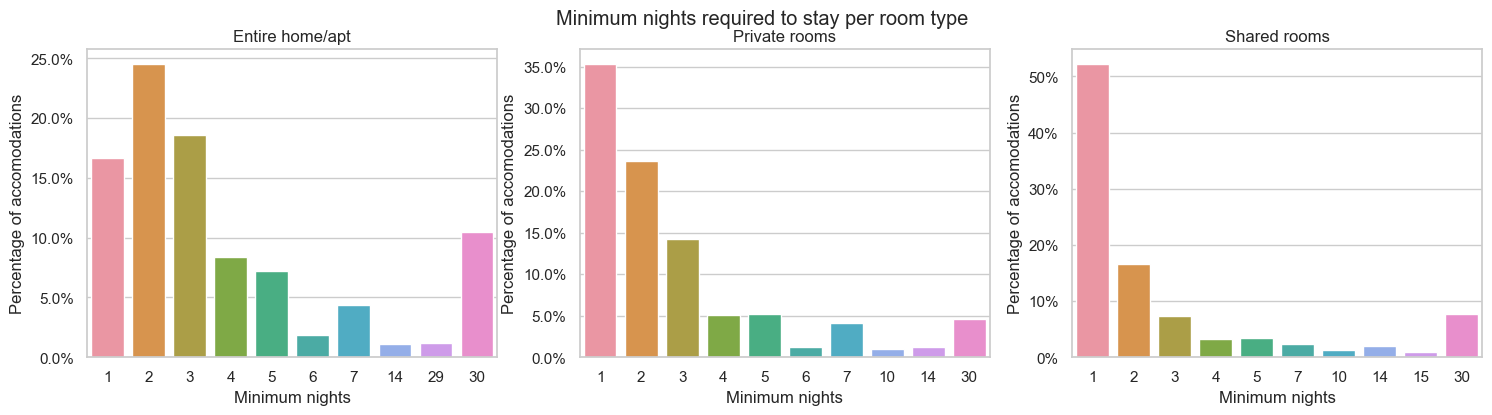

In [44]:
fig , axes = plt.subplots(1,3,figsize=(18,4))
plt.rcParams["figure.figsize"] = [6.00, 3.50]

sns.barplot(data=ent_home.head(10),x='minimum_nights_a_year',y='listings_percentage',ax=axes[0])
axes[0].set_title('Entire home/apt')
axes[0].set_xlabel('Minimum nights')
axes[0].set_ylabel('Percentage of accomodations')
axes[0].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(data=private.head(10),x='minimum_nights_a_year',y='listings_percentage',ax=axes[1])
axes[1].set_title('Private rooms')
axes[1].set_xlabel('Minimum nights')
axes[1].set_ylabel('Percentage of accomodations')
axes[1].yaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(data=shared.head(10),x='minimum_nights_a_year',y='listings_percentage',ax=axes[2])
axes[2].set_title('Shared rooms')
axes[2].set_xlabel('Minimum nights')
axes[2].set_ylabel('Percentage of accomodations')
axes[2].yaxis.set_major_formatter(mtick.PercentFormatter())

plt.suptitle('Minimum nights required to stay per room type')

plt.show()

Most listings are for people to stay at least one night. For private rooms it is more common for hosts to ask for at least one or two nights, but for entire apartments or homes it can also be possible for hosts to ask for people to stay longer. It is more common for hosts to ask for a stay of at least a month than to stay at least 4 days.

### Hosts analysis

In [ ]:
hosts = nyc_airbnb_data.groupby(['host_id','calculated_host_listings_count','neighbourhood_group']).agg({'reviews_per_month':'mean','price':'mean','number_of_reviews':'mean','availability_365':'mean'}).reset_index()
hosts['host_id'] = hosts['host_id'].astype('category')

In [ ]:
top_hosts = hosts.sort_values('calculated_host_listings_count',ascending=False).reset_index()

In [ ]:
top_hosts_data = nyc_airbnb_data[nyc_airbnb_data['host_id'].isin(top_hosts['host_id'].unique()[0:5])]
top_hosts_data.loc[:,'host_id'] = top_hosts_data.loc[:,'host_id'].astype(str)

c:\Users\nelly\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [ ]:
top_hosts_data.loc[:,'availability_percentage'] = 100* top_hosts_data['availability_365'] / 365

c:\Users\nelly\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


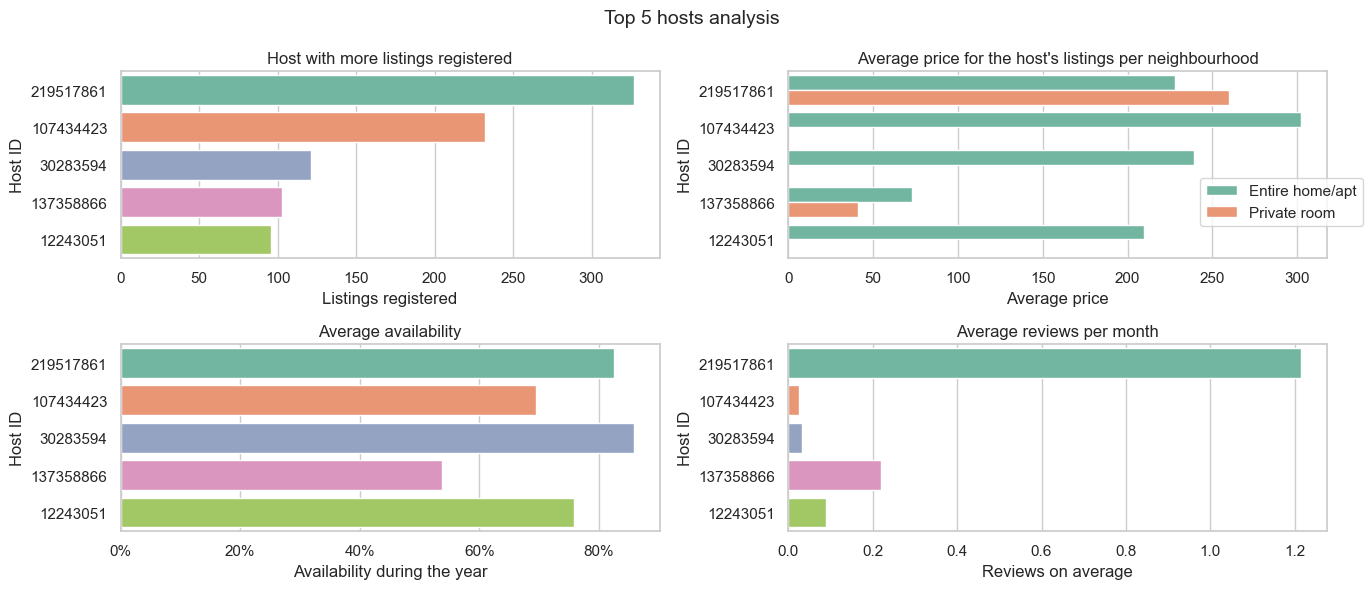

In [ ]:
fig, axes = plt.subplots(2,2,figsize=(14,6))

plt.rcParams["figure.figsize"] = [6.00, 3.50]
plt.rcParams["figure.autolayout"] = True

sns.barplot(data=top_hosts_data, y='host_id',x='calculated_host_listings_count',ax=axes[0,0], 
            order=['219517861','107434423','30283594', '137358866','12243051'])
axes[0,0].set_title('Host with more listings registered',fontsize=12)
axes[0,0].set_ylabel('Host ID')
axes[0,0].set_xlabel('Listings registered')

sns.barplot(data=top_hosts_data, y='host_id',x='price',ax=axes[0,1],hue='room_type',estimator=np.median,ci=None, 
            order=['219517861','107434423','30283594', '137358866','12243051'])
axes[0,1].set_title("Average price for the host's listings per neighbourhood",fontsize=12)
axes[0,1].legend(loc='center left', bbox_to_anchor=(0.75, 0.3))
axes[0,1].set_ylabel('Host ID')
axes[0,1].set_xlabel('Average price')

sns.barplot(data=top_hosts_data, y='host_id', x='availability_percentage',estimator=np.mean,ci=None, ax=axes[1,0],
            order=['219517861','107434423','30283594', '137358866','12243051'])
axes[1,0].set_title('Average availability',fontsize=12)
axes[1,0].set_ylabel('Host ID')
axes[1,0].set_xlabel('Availability during the year')
axes[1,0].xaxis.set_major_formatter(mtick.PercentFormatter())

sns.barplot(data=top_hosts_data, y='host_id', x='reviews_per_month',estimator=np.mean, ci=None,ax=axes[1,1],
             order=['219517861','107434423','30283594', '137358866','12243051'])
axes[1,1].set_title('Average reviews per month',fontsize=12)
axes[1,1].set_ylabel('Host ID')
axes[1,1].set_xlabel('Reviews on average')

plt.suptitle('Top 5 hosts analysis',fontsize=14)
plt.show()

According to the results above:
* The top 5 hosts with more listings from almost 100 to more than 300 listings
* Most of them have their propierties in Manhattan.
* Only one host have propierties in Manhattan, Brooklyn and Queens. But the average prices are very similar. This host shows much lower prices than the other hosts.
* The second host with more listings is the one who offers higher prices with listings in Manhattan and Brooklyn.
* All hosts show more than 50% of availability during the year.
* The only host that stands out for reviews is the 219517861, the host with more listings. This host has on average 1.2 reviews per month. While the rest of the hosts barely receive reviews.

## Highlights and conclusion    

* Most of the accomodations in NYC are in Brooklyn or Manhattan, and most of them are homes and apartments.
* People could pay aproximately the same for a private room in Brooklyn and a shared room in Manhattan
* There is no statistical difference in the median prices for accomodations in Queens, Staten Island and Bronx.
* Manhattan has the most expensive accomodations and there are mostly homes and apartments to rent there.
* Almost a quarter of homes/apt to rent are required to stay at least 2 nights, and 10% are required to stay 30 days.
* Most hosts with more accomodations offer prices above $200 on average.